In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import auc
import numpy as np

In [15]:
# Import results
path = "./results/idm"
results = os.listdir(path)

# Choose which to plot
r_path = f"{path}/exp_2-compl39.csv"
r = pd.read_csv(r_path).drop("Unnamed: 0", axis=1)

n_bns = r.shape[1] - 3
r_bns = r.iloc[:,-n_bns:]

# r_bns.columns

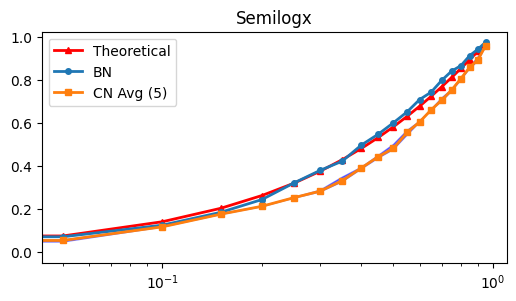

In [16]:
## Plot: error vs power (semilogx)
fig, ax = plt.subplots(1,1, figsize=(6, 3))
kwargs = {"lw":2, "ms":4, "alpha": 1}

# Theoretical bound
ax.semilogx(r["error"], r["power_bound"], "r-^", label = 'Theoretical', **kwargs)

# BN
ax.semilogx(r["error"], r["power_BN"], "-o", label = 'BN', **kwargs)

# CN (avg, min, max)
ax.semilogx(r["error"], r_bns.mean(axis=1), "-s", label = f'CN Avg ({n_bns})', **kwargs)
ax.fill_between(r["error"], r_bns.min(axis=1), r_bns.max(axis=1), color="b", alpha=0.5)

# Plot info
ax.set(title='Semilogx')
ax.legend()

In [17]:
# Compute AUCs
print(f"BN AUC: {auc(r['error'], r['power_BN'])}")
print(f"CN Avg AUC: {auc(r['error'], r_bns.mean(axis=1))}")

BN AUC: 0.5171067106710671
CN Avg AUC: 0.45298129812981286
